# State Farm Distracted Driver Training Notebook

In [1]:
from fastai.vision.all import *

seed = 42
set_seed(seed, reproducible=True)

%config Completer.use_jedi = False
%matplotlib inline

# matplotlib.pyplot.style.use('dracula')

Set hyperparameters for the notebook here:

In [2]:
# Hyperparameters
valid_pct = 0.2
presize_cpu = 480   # Resized size before batch augmentation on gpu
presize_gpu = 224   # Batch augmentation size on gpu.

In [3]:
path = Path('/media/xar/barracuda1/fast.ai/data/state-farm-driver/')
path.ls()

(#4) [Path('/media/xar/barracuda1/fast.ai/data/state-farm-driver/driver_imgs_list.csv'),Path('/media/xar/barracuda1/fast.ai/data/state-farm-driver/sample_submission.csv'),Path('/media/xar/barracuda1/fast.ai/data/state-farm-driver/state-farm-distracted-driver-detection.zip'),Path('/media/xar/barracuda1/fast.ai/data/state-farm-driver/imgs')]

In [4]:
Path.BASE_PATH = path

In [5]:
(path/'imgs'/'train').ls()

(#10) [Path('imgs/train/c6'),Path('imgs/train/c7'),Path('imgs/train/c1'),Path('imgs/train/c4'),Path('imgs/train/c5'),Path('imgs/train/c0'),Path('imgs/train/c9'),Path('imgs/train/c3'),Path('imgs/train/c2'),Path('imgs/train/c8')]

In [6]:
(path/'imgs'/'test').ls()

(#79726) [Path('imgs/test/img_57185.jpg'),Path('imgs/test/img_71109.jpg'),Path('imgs/test/img_81875.jpg'),Path('imgs/test/img_101255.jpg'),Path('imgs/test/img_54069.jpg'),Path('imgs/test/img_43476.jpg'),Path('imgs/test/img_49549.jpg'),Path('imgs/test/img_60406.jpg'),Path('imgs/test/img_91426.jpg'),Path('imgs/test/img_4920.jpg')...]

The labels of the training images are in `imgs/driver_imgs_list.csv` which is a comma-delimited list for each image denoting: driver, class name, and image name.

In [7]:
df = pd.read_csv(path/'driver_imgs_list.csv')
df

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg
...,...,...,...
22419,p081,c9,img_56936.jpg
22420,p081,c9,img_46218.jpg
22421,p081,c9,img_25946.jpg
22422,p081,c9,img_67850.jpg


In [8]:
df['classname'].unique()

array(['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'],
      dtype=object)

**Classes:**

`c0`: normal driving

`c1`: texting right hand

`c2`: phone call right hand

`c3`: texting left hand

`c4`: phone call left hand

`c5`: radio

`c6`: drinking

`c7`: grabbing something from back seat

`c8`: hair and makeup

`c9`: looking away talking

height: 480 width: 640


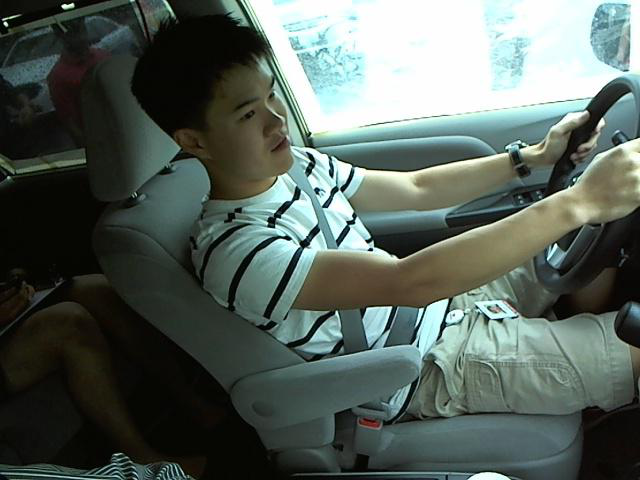

In [9]:
index = 695
im = Image.open(path/'imgs'/'train'/df['classname'][index]/df['img'][index])
print('height:', im.height, 'width:', im.width)
im

In [10]:
def get_x(df): return path/'imgs'/'train'/df['classname']/df['img']
def get_y(df): return df['classname'].split(',')

In [11]:
# dblock = DataBlock(
#     blocks=[ImageBlock, MultiCategoryBlock],
#     get_x=get_x,
#     get_y=get_y,
#     splitter=RandomSplitter(valid_pct=valid_pct),
#     item_tfms=Resize(presize_cpu),
#     batch_tfms=aug_transforms(size=presize_gpu, min_scale=0.75)
# )

# # dsets = dblock.datasets(df)
# # dsets.train[0]
# dls = dblock.dataloaders(df)
# # dls.show_batch(nrows=1, ncols=3)

Check that it's reading the labels correctly,

In [12]:
# dls.vocab, len(dls.vocab)

In [13]:
# learn = cnn_learner(dls, arch=resnet18)
# x,y = to_cpu(dls.train.one_batch())
# activations = learn.model(x)
# print('activations.shape:', activations.shape)

# print('activations:', activations[0])
# loss_func = nn.BCEWithLogitsLoss()
# prtin(loss_func(activations, y))

Create class to setup the model and run it. Save duplicatation of code.

In [14]:
# test __call__
class test_class():
    def __init__(self, a):
        self.a = a
    def __call__(self):
        print('__call__ activated')
        print('self.a:', self.a)
    def run():
        print('run activated')
        print('self.a:', self.a)

tc = test_class(10)
tc()

__call__ activated
self.a: 10


In [15]:
# learn.lr_find??
Learner.lr_find??

Signature:
Learner.lr_find(
    self: fastai.learner.Learner,
    start_lr=1e-07,
    end_lr=10,
    num_it=100,
    stop_div=True,
    show_plot=True,
    suggest_funcs=<function valley at 0x7f933e727700>,
)
Source:   
@patch
def lr_find(self:Learner, start_lr=1e-7, end_lr=10, num_it=100, stop_div=True, show_plot=True, suggest_funcs=(SuggestionMethod.Valley)):
    "Launch a mock training to find a good learning rate and return suggestions based on `suggest_funcs` as a named tuple"
    n_epoch = num_it//len(self.dls.train) + 1
    cb=LRFinder(start_lr=start_lr, end_lr=end_lr, num_it=num_it, stop_div=stop_div)
    with self.no_logging(): self.fit(n_epoch, cbs=cb)
    if suggest_funcs is not None:
        lrs, losses = tensor(self.recorder.lrs[num_it//10:-5]), tensor(self.recorder.losses[num_it//10:-5])
        nan_idxs = torch.nonzero(torch.isnan(losses.view(-1)))
        if len(nan_idxs) > 0:
            drop_idx = min(nan_idxs)
            lrs = lrs[:drop_idx]
            losses = los

In [16]:
class CNN_Presized():
    def __init__(self, df, get_x, get_y, valid_pct, presize_cpu, presize_gpu, batch_size, arch, weight_decay, monitor='valid_loss'):
        self.df             = df
        self.get_x          = get_x
        self.get_y          = get_y
        self.valid_pct      = valid_pct
        self.presize_cpu    = presize_cpu
        self.presize_gpu    = presize_gpu
        self.batch_size     = batch_size
        self.arch           = arch
        self.weight_decay   = weight_decay
        self.monitor        = monitor
    # def __call__(self):
        dblock = DataBlock(
            blocks=[ImageBlock, MultiCategoryBlock],
            get_x=self.get_x,
            get_y=self.get_y,
            splitter=RandomSplitter(valid_pct=self.valid_pct),
            item_tfms=Resize(self.presize_cpu),
            batch_tfms=aug_transforms(size=self.presize_gpu, min_scale=0.75)
        )
        dls = dblock.dataloaders(self.df, bs=self.batch_size)
        loss_func = nn.BCEWithLogitsLoss()
        self.learn = cnn_learner(
            dls,
            arch=self.arch,
            loss_func=loss_func,
            metrics=F1ScoreMulti(thresh=0.5),
            cbs=[
                # ShowGraphCallback(),
                SaveModelCallback(
                    monitor=self.monitor,
                    # fname=str(self.arch+'_'+self.monitor+'_'+self.presize_gpu+'px'+'_'+'wd'+self.weight_decay)
                    fname=str(self.arch).split()[1]+'_'+self.monitor+'_'+str(self.presize_cpu)+'cpx'+'_'+str(self.presize_gpu)+'gpx'+'_'+str(self.weight_decay)+'wd'
                ),
                EarlyStoppingCallback(
                    monitor=self.monitor,
                    patience=3
                )
            ]
        )
        # self.learn = learn
        # return learn
    def lrs(self):
        self.learning_rates = self.learn.lr_find(suggest_funcs=(SuggestionMethod.Valley,SuggestionMethod.Minimum,SuggestionMethod.Slide))
        print(self.learning_rates)
    def run(self, n_epochs, base_lr='valley'):
        self.n_epochs = n_epochs
        if base_lr=='valley': base_lr = self.learning_rates.valley
        if base_lr=='minimum': base_lr = self.learning_rates.minimum
        if base_lr=='slide': base_lr = self.learning_rates.slide
        self.learn.fine_tune(self.n_epochs, base_lr=base_lr, wd=self.weight_decay)
    def export(self, pkl_name): self.learn.export(str(self.pkl_name) + '.pkl')
    def load(self, pkl_name): self.learn.load_learner(str(self.pkl_name) + '.pkl', cpu=False)

# Resnet18

## Presize 480/224

In [17]:
presize_cpu = 480
presize_gpu = 224

### wd = 0.1

In [18]:
res18_01 = CNN_Presized(df, get_x, get_y, valid_pct, presize_cpu, presize_gpu, batch_size=256, arch=resnet18, weight_decay=0.1)

SuggestedLRs(valley=0.002511886414140463, minimum=0.03630780577659607, slide=0.02290867641568184)


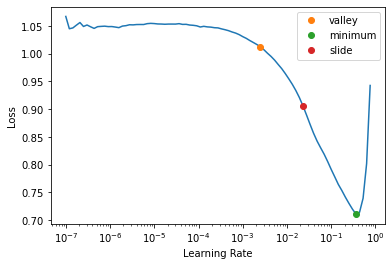

In [19]:
res18_01.lrs()

In [20]:
# testing
res18_01.run(6, base_lr='valley')

epoch,train_loss,valid_loss,f1_score,time
0,0.711392,0.287041,0.698483,00:55


Better model found at epoch 0 with valid_loss value: 0.28704050183296204.


epoch,train_loss,valid_loss,f1_score,time
0,0.265036,0.106712,0.878248,00:58
1,0.121458,0.027148,0.961193,00:58
2,0.053176,0.012905,0.981741,00:58
3,0.026865,0.007852,0.989088,00:58
4,0.016115,0.006254,0.991701,00:59
5,0.012503,0.006106,0.991719,00:58


Better model found at epoch 0 with valid_loss value: 0.10671225190162659.
Better model found at epoch 1 with valid_loss value: 0.027147715911269188.
Better model found at epoch 2 with valid_loss value: 0.012905114330351353.
Better model found at epoch 3 with valid_loss value: 0.007852411828935146.
Better model found at epoch 4 with valid_loss value: 0.006254047155380249.
Better model found at epoch 5 with valid_loss value: 0.0061057074926793575.


SuggestedLRs(valley=0.00010964782268274575, minimum=1.318256749982538e-07, slide=0.0002290867705596611)


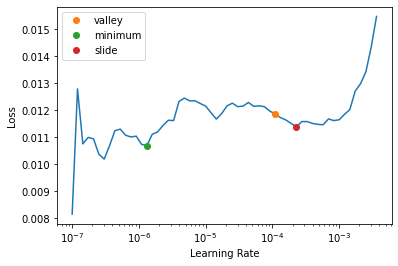

In [21]:
res18_01.lrs()

In [22]:
res18_01.run(2, base_lr='valley')

epoch,train_loss,valid_loss,f1_score,time
0,0.011190,0.005841,0.991742,01:01


Better model found at epoch 0 with valid_loss value: 0.00584137300029397.


epoch,train_loss,valid_loss,f1_score,time
0,0.010096,0.005674,0.992216,00:59
1,0.010044,0.005499,0.992517,01:00


Better model found at epoch 0 with valid_loss value: 0.0056744348257780075.
Better model found at epoch 1 with valid_loss value: 0.005498741753399372.


SuggestedLRs(valley=1.737800812406931e-05, minimum=5.248074739938602e-06, slide=0.0002754228771664202)


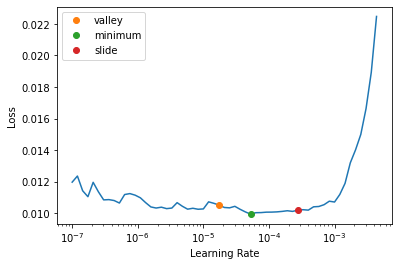

In [23]:
res18_01.lrs()

In [24]:
res18_01.run(2, base_lr='valley')

epoch,train_loss,valid_loss,f1_score,time
0,0.009618,0.005490,0.992430,00:56


Better model found at epoch 0 with valid_loss value: 0.005490328185260296.


epoch,train_loss,valid_loss,f1_score,time
0,0.010044,0.005480,0.992354,00:58
1,0.010305,0.005407,0.992331,00:58


Better model found at epoch 0 with valid_loss value: 0.005479692947119474.
Better model found at epoch 1 with valid_loss value: 0.005407053045928478.


SuggestedLRs(valley=9.120108734350652e-05, minimum=2.7542287716642023e-05, slide=0.0002754228771664202)


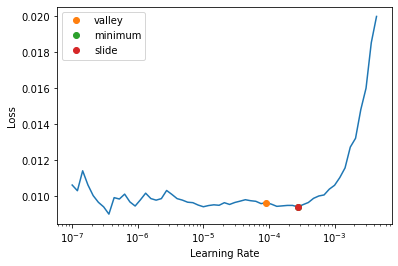

In [25]:
res18_01.lrs()

### wd = 0.2

In [ ]:
res18_02 = CNN_Presized(df, get_x, get_y, valid_pct, presize_cpu, presize_gpu, batch_size=256, arch=resnet18, weight_decay=0.2)

SuggestedLRs(valley=0.002511886414140463, minimum=0.03630780577659607, slide=0.02290867641568184)


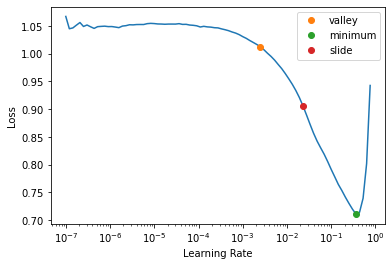

In [ ]:
res18_02.lrs()

In [ ]:
res18_02.run(6, base_lr='valley')

epoch,train_loss,valid_loss,f1_score,time
0,0.710903,0.288017,0.698444,01:03


Better model found at epoch 0 with valid_loss value: 0.28801706433296204.


epoch,train_loss,valid_loss,f1_score,time
0,0.265113,0.107524,0.880252,00:58
1,0.121464,0.027856,0.960200,01:00
2,0.053207,0.012792,0.982806,00:59
3,0.026924,0.008008,0.988629,01:00
4,0.016133,0.006320,0.991605,01:00
5,0.012489,0.006152,0.992134,01:00


Better model found at epoch 0 with valid_loss value: 0.10752366483211517.
Better model found at epoch 1 with valid_loss value: 0.02785569243133068.
Better model found at epoch 2 with valid_loss value: 0.012791642919182777.
Better model found at epoch 3 with valid_loss value: 0.008008487522602081.
Better model found at epoch 4 with valid_loss value: 0.006320093758404255.
Better model found at epoch 5 with valid_loss value: 0.0061519090086221695.


SuggestedLRs(valley=0.00015848931798245758, minimum=1.318256749982538e-07, slide=0.0002290867705596611)


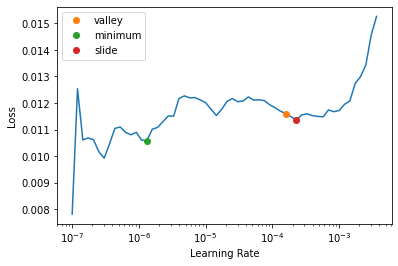

In [ ]:
res18_02.lrs()

In [ ]:
res18_02.run(3, base_lr='valley')

epoch,train_loss,valid_loss,f1_score,time
0,0.011136,0.005823,0.992159,00:57


Better model found at epoch 0 with valid_loss value: 0.005822929088026285.


epoch,train_loss,valid_loss,f1_score,time
0,0.009923,0.005587,0.992053,00:58
1,0.009692,0.005152,0.992964,01:00
2,0.009239,0.005149,0.992988,00:58


Better model found at epoch 0 with valid_loss value: 0.005586607381701469.
Better model found at epoch 1 with valid_loss value: 0.005151967518031597.
Better model found at epoch 2 with valid_loss value: 0.005148968193680048.


SuggestedLRs(valley=5.248074739938602e-05, minimum=2.7542287716642023e-05, slide=0.0002290867705596611)


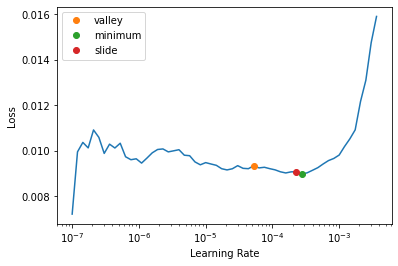

In [ ]:
res18_02.lrs()

In [ ]:
res18_02.run(3, base_lr='valley')

epoch,train_loss,valid_loss,f1_score,time
0,0.009035,0.005092,0.992861,00:57


Better model found at epoch 0 with valid_loss value: 0.005091947037726641.


epoch,train_loss,valid_loss,f1_score,time
0,0.009357,0.004966,0.993101,01:01
1,0.009043,0.004895,0.993439,01:02
2,0.008660,0.004813,0.993218,01:03


Better model found at epoch 0 with valid_loss value: 0.00496626878157258.
Better model found at epoch 1 with valid_loss value: 0.004894875921308994.
Better model found at epoch 2 with valid_loss value: 0.00481298565864563.


SuggestedLRs(valley=2.0892961401841603e-05, minimum=1.9054606673307718e-05, slide=0.0002290867705596611)


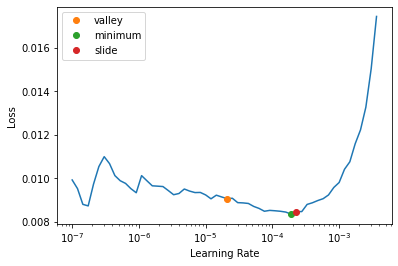

In [ ]:
res18_02.lrs()

In [ ]:
res18_02.run(3, base_lr='valley')

epoch,train_loss,valid_loss,f1_score,time
0,0.008350,0.004875,0.993342,01:00


Better model found at epoch 0 with valid_loss value: 0.004874630831182003.


epoch,train_loss,valid_loss,f1_score,time
0,0.008351,0.004783,0.993445,00:59
1,0.008025,0.004750,0.993329,00:59
2,0.008102,0.004763,0.993331,00:59


Better model found at epoch 0 with valid_loss value: 0.004782885778695345.
Better model found at epoch 1 with valid_loss value: 0.004750004969537258.


SuggestedLRs(valley=1.0964781722577754e-06, minimum=9.12010818865383e-08, slide=0.00015848931798245758)


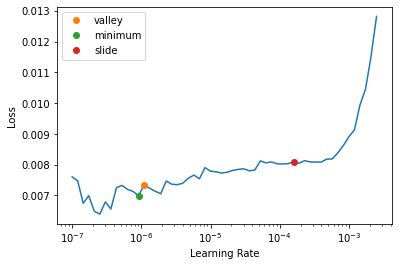

In [ ]:
res18_02.lrs()

### wd = 0.3

In [ ]:
res18_03 = CNN_Presized(df, get_x, get_y, valid_pct, presize_cpu, presize_gpu, batch_size=256, arch=resnet18, weight_decay=0.3)

SuggestedLRs(valley=0.001737800776027143, minimum=0.03630780577659607, slide=0.019054606556892395)


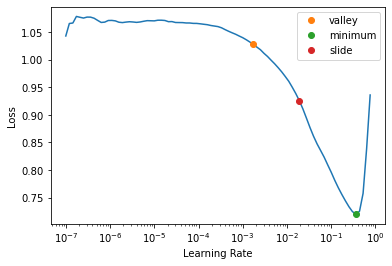

In [ ]:
res18_03.lrs()

In [ ]:
res18_03.run(6, base_lr='valley')

epoch,train_loss,valid_loss,f1_score,time
0,0.779710,0.419797,0.543095,00:57


Better model found at epoch 0 with valid_loss value: 0.419796884059906.


epoch,train_loss,valid_loss,f1_score,time
0,0.437054,0.246336,0.774844,00:59
1,0.235174,0.065472,0.934618,00:59
2,0.107780,0.026356,0.970918,00:59
3,0.055687,0.016266,0.980223,00:58
4,0.035197,0.013325,0.982831,00:59
5,0.028171,0.012981,0.982739,01:00


Better model found at epoch 0 with valid_loss value: 0.24633634090423584.
Better model found at epoch 1 with valid_loss value: 0.06547226756811142.
Better model found at epoch 2 with valid_loss value: 0.026356304064393044.
Better model found at epoch 3 with valid_loss value: 0.016265878453850746.
Better model found at epoch 4 with valid_loss value: 0.01332542672753334.
Better model found at epoch 5 with valid_loss value: 0.012980800122022629.


SuggestedLRs(valley=0.00019054606673307717, minimum=6.309573450380412e-08, slide=0.0008317637839354575)


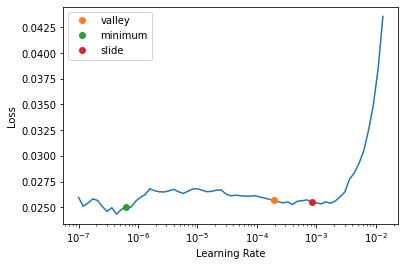

In [ ]:
res18_03.lrs()

In [ ]:
res18_03.run(3, base_lr='valley')

epoch,train_loss,valid_loss,f1_score,time
0,0.024790,0.011681,0.983745,01:00


Better model found at epoch 0 with valid_loss value: 0.011680667288601398.


epoch,train_loss,valid_loss,f1_score,time
0,0.022760,0.010569,0.985267,01:02
1,0.020604,0.009657,0.986630,01:02
2,0.019210,0.009362,0.986586,01:03


Better model found at epoch 0 with valid_loss value: 0.01056933868676424.
Better model found at epoch 1 with valid_loss value: 0.00965678971260786.
Better model found at epoch 2 with valid_loss value: 0.009362262673676014.


SuggestedLRs(valley=1.737800812406931e-05, minimum=9.120108734350651e-06, slide=0.0004786300996784121)


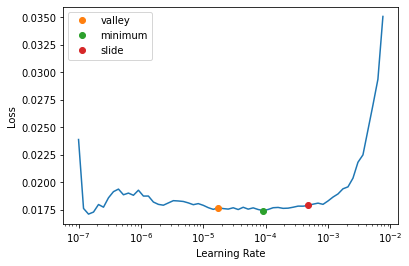

In [ ]:
res18_03.lrs()

In [ ]:
res18_03.run(3, base_lr='valley')

epoch,train_loss,valid_loss,f1_score,time
0,0.018557,0.009351,0.986886,00:55


Better model found at epoch 0 with valid_loss value: 0.009351302869617939.


epoch,train_loss,valid_loss,f1_score,time
0,0.018408,0.009228,0.986854,00:58
1,0.018192,0.009066,0.987066,00:59
2,0.018199,0.009051,0.987130,00:58


Better model found at epoch 0 with valid_loss value: 0.009228193201124668.
Better model found at epoch 1 with valid_loss value: 0.009066328406333923.
Better model found at epoch 2 with valid_loss value: 0.009050928987562656.


SuggestedLRs(valley=7.585775892948732e-05, minimum=6.30957365501672e-06, slide=0.0003311311302240938)


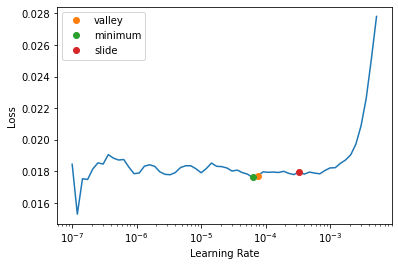

In [ ]:
res18_03.lrs()

## Presize 480/480

In [ ]:
presize_cpu = 480
presize_gpu = 480

### wd = 0.1

In [ ]:
res18_11 = CNN_Presized(df, get_x, get_y, valid_pct, presize_cpu, presize_gpu, batch_size=64, arch=resnet18, weight_decay=0.1)

SuggestedLRs(valley=0.00363078061491251, minimum=0.025118863582611083, slide=0.015848932787775993)


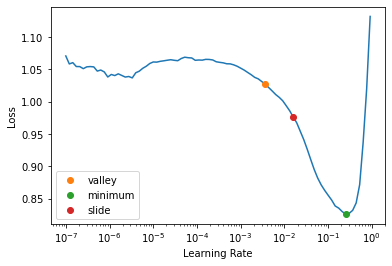

In [ ]:
res18_11.lrs()

In [ ]:
res18_11.run(6, base_lr='valley')

epoch,train_loss,valid_loss,f1_score,time
0,0.215737,0.115425,0.771085,01:46


Better model found at epoch 0 with valid_loss value: 0.11542507261037827.


epoch,train_loss,valid_loss,f1_score,time
0,0.035378,0.015688,0.974860,02:06
1,0.015946,0.009112,0.985106,02:07
2,0.009538,0.004731,0.991693,02:07
3,0.004248,0.002491,0.996326,02:07
4,0.002144,0.001223,0.998647,02:08
5,0.001477,0.001145,0.998518,02:07


Better model found at epoch 0 with valid_loss value: 0.01568784937262535.
Better model found at epoch 1 with valid_loss value: 0.00911172665655613.
Better model found at epoch 2 with valid_loss value: 0.004731259308755398.
Better model found at epoch 3 with valid_loss value: 0.002490666462108493.
Better model found at epoch 4 with valid_loss value: 0.00122318253852427.
Better model found at epoch 5 with valid_loss value: 0.0011449394514784217.


SuggestedLRs(valley=0.00015848931798245758, minimum=1.2022644114040304e-06, slide=3.630780702224001e-05)


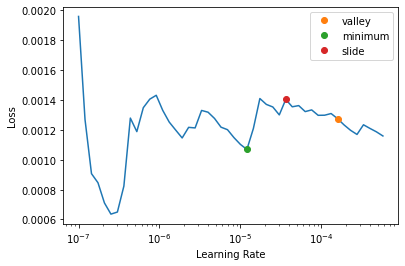

In [ ]:
res18_11.lrs()

In [ ]:
res18_11.run(3, base_lr='valley')

epoch,train_loss,valid_loss,f1_score,time
0,0.001115,0.001136,0.998626,01:48


Better model found at epoch 0 with valid_loss value: 0.001135614118538797.


epoch,train_loss,valid_loss,f1_score,time
0,0.000929,0.001104,0.998607,02:07
1,0.001036,0.001167,0.998478,02:07
2,0.000687,0.001085,0.998709,02:07


Better model found at epoch 0 with valid_loss value: 0.00110414728987962.
Better model found at epoch 2 with valid_loss value: 0.0010853507556021214.


SuggestedLRs(valley=1.4454397387453355e-05, minimum=6.30957365501672e-06, slide=3.0199516913853586e-05)


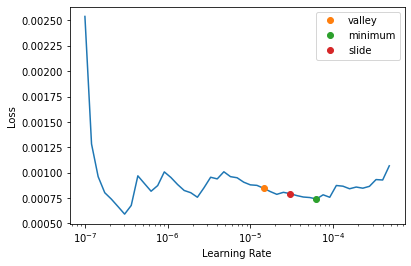

In [ ]:
res18_11.lrs()

In [ ]:
res18_11.run(3, base_lr='valley')

epoch,train_loss,valid_loss,f1_score,time
0,0.000712,0.001089,0.998709,01:47


Better model found at epoch 0 with valid_loss value: 0.0010888611432164907.


epoch,train_loss,valid_loss,f1_score,time
0,0.000837,0.001113,0.998607,02:07
1,0.001066,0.001141,0.998375,02:08
2,0.000744,0.001069,0.998709,02:07


Better model found at epoch 0 with valid_loss value: 0.001113122678361833.
Better model found at epoch 2 with valid_loss value: 0.001069122925400734.


SuggestedLRs(valley=7.585775892948732e-05, minimum=1.58489319801447e-07, slide=3.0199516913853586e-05)


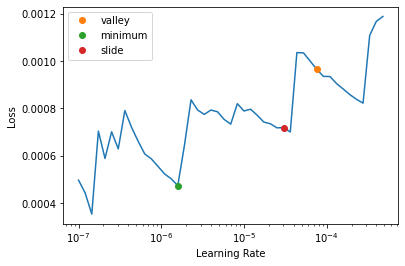

In [ ]:
res18_11.lrs()

In [ ]:
res18_11.run(3, base_lr='valley')

epoch,train_loss,valid_loss,f1_score,time
0,0.000805,0.001139,0.998478,01:47


Better model found at epoch 0 with valid_loss value: 0.001138719148002565.


epoch,train_loss,valid_loss,f1_score,time
0,0.000507,0.001125,0.998607,02:07
1,0.000827,0.001117,0.998478,02:08
2,0.001015,0.001076,0.998709,02:08


Better model found at epoch 0 with valid_loss value: 0.001125027542002499.
Better model found at epoch 1 with valid_loss value: 0.0011173603124916553.
Better model found at epoch 2 with valid_loss value: 0.0010760667501017451.


SuggestedLRs(valley=1.0964781722577754e-06, minimum=3.311311274956097e-07, slide=1.737800812406931e-05)


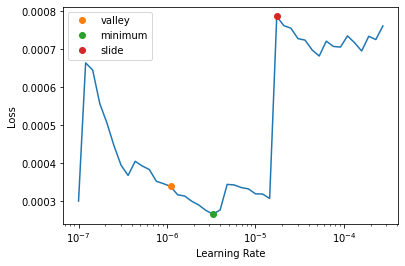

In [ ]:
res18_11.lrs()

In [ ]:
res18_11.run(4, base_lr='valley')

epoch,train_loss,valid_loss,f1_score,time
0,0.000606,0.001159,0.998478,01:47


Better model found at epoch 0 with valid_loss value: 0.0011590090580284595.


epoch,train_loss,valid_loss,f1_score,time
0,0.000616,0.001093,0.998478,02:08
1,0.000675,0.001085,0.998709,02:08
2,0.000796,0.001170,0.998375,02:08
3,0.000633,0.001130,0.998626,02:08


Better model found at epoch 0 with valid_loss value: 0.001092635910026729.
Better model found at epoch 1 with valid_loss value: 0.001085351686924696.


SuggestedLRs(valley=6.918309736647643e-06, minimum=6.309573450380412e-08, slide=2.0892961401841603e-05)


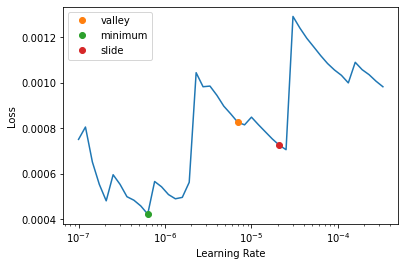

In [ ]:
res18_11.lrs()

### wd = 0.2

In [ ]:
res18_12 = CNN_Presized(df, get_x, get_y, valid_pct, presize_cpu, presize_gpu, batch_size=64, arch=resnet18, weight_decay=0.2)

SuggestedLRs(valley=0.00363078061491251, minimum=0.025118863582611083, slide=0.015848932787775993)


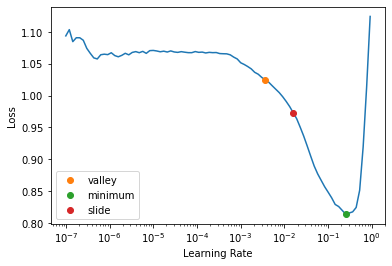

In [ ]:
res18_12.lrs()

In [ ]:
res18_12.run(6, base_lr='valley')

epoch,train_loss,valid_loss,f1_score,time
0,0.217405,0.100896,0.790192,01:12


Better model found at epoch 0 with valid_loss value: 0.1008964255452156.


epoch,train_loss,valid_loss,f1_score,time
0,0.036620,0.015242,0.973691,00:58
1,0.019332,0.008246,0.986623,01:00
2,0.010596,0.005309,0.990663,01:00
3,0.006736,0.005183,0.990145,01:00
4,0.002889,0.001800,0.997765,01:00
5,0.001700,0.001490,0.997999,01:01


Better model found at epoch 0 with valid_loss value: 0.015241731889545918.
Better model found at epoch 1 with valid_loss value: 0.008245807141065598.
Better model found at epoch 2 with valid_loss value: 0.0053091044537723064.
Better model found at epoch 3 with valid_loss value: 0.005183055996894836.
Better model found at epoch 4 with valid_loss value: 0.001799620222300291.
Better model found at epoch 5 with valid_loss value: 0.0014900799142196774.


SuggestedLRs(valley=0.00013182566908653826, minimum=2.7542287170945203e-07, slide=5.248074739938602e-05)


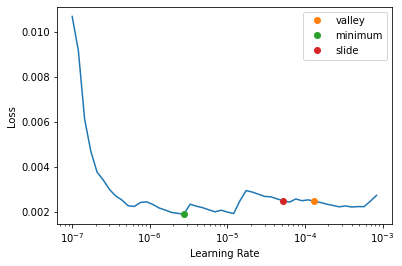

In [ ]:
res18_12.lrs()

In [ ]:
res18_12.run(3, base_lr='valley')

epoch,train_loss,valid_loss,f1_score,time
0,0.001727,0.001445,0.997999,00:59


Better model found at epoch 0 with valid_loss value: 0.0014447225257754326.


epoch,train_loss,valid_loss,f1_score,time
0,0.001597,0.001371,0.998084,01:01
1,0.001679,0.001501,0.998088,01:02
2,0.001247,0.001352,0.998557,01:01


Better model found at epoch 0 with valid_loss value: 0.0013712835498154163.
Better model found at epoch 2 with valid_loss value: 0.0013517998158931732.


SuggestedLRs(valley=3.981071586167673e-06, minimum=1.4454397387453355e-06, slide=5.248074739938602e-05)


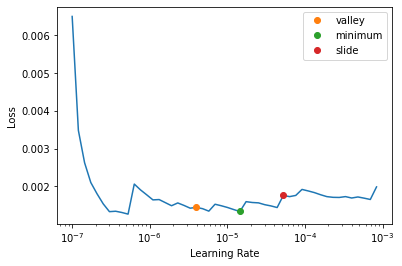

In [ ]:
res18_12.lrs()

In [ ]:
res18_12.run(2, base_lr='valley')

epoch,train_loss,valid_loss,f1_score,time
0,0.001373,0.001339,0.998679,00:55


Better model found at epoch 0 with valid_loss value: 0.0013387276558205485.


epoch,train_loss,valid_loss,f1_score,time
0,0.001798,0.001411,0.998299,00:58
1,0.001371,0.001277,0.998450,00:59


Better model found at epoch 0 with valid_loss value: 0.001411133329384029.
Better model found at epoch 1 with valid_loss value: 0.0012769930763170123.


SuggestedLRs(valley=1.737800812406931e-05, minimum=3.311311302240938e-05, slide=5.248074739938602e-05)


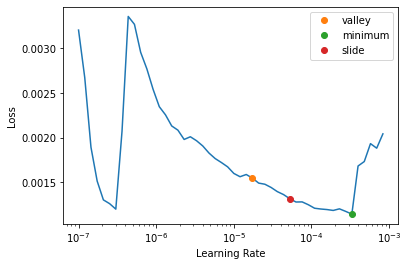

In [ ]:
res18_12.lrs()

In [ ]:
res18_12.run(2, base_lr='valley')

epoch,train_loss,valid_loss,f1_score,time
0,0.001655,0.001377,0.998578,00:59


Better model found at epoch 0 with valid_loss value: 0.0013770819641649723.


epoch,train_loss,valid_loss,f1_score,time
0,0.000960,0.001300,0.998685,01:00
1,0.001409,0.001374,0.998557,01:00


Better model found at epoch 0 with valid_loss value: 0.0012996658915653825.


SuggestedLRs(valley=8.31763736641733e-06, minimum=7.585775847473997e-08, slide=2.0892961401841603e-05)


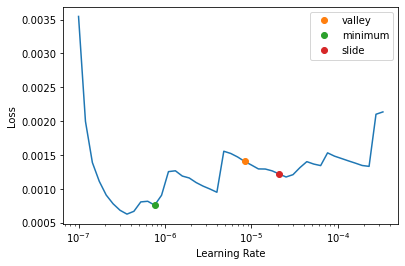

In [ ]:
res18_12.lrs()

### wd = 0.3

In [26]:
res18_13 = CNN_Presized(df, get_x, get_y, valid_pct, presize_cpu, presize_gpu, batch_size=64, arch=resnet18, weight_decay=0.3)

SuggestedLRs(valley=0.002511886414140463, minimum=0.025118863582611083, slide=0.013182567432522774)


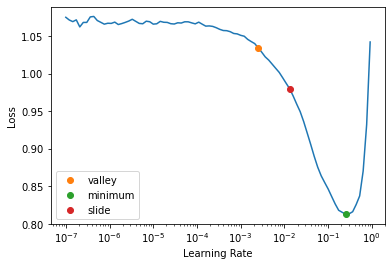

In [27]:
res18_13.lrs()

In [28]:
res18_13.run(6, base_lr='valley')

epoch,train_loss,valid_loss,f1_score,time
0,0.249087,0.111495,0.747073,00:58


Better model found at epoch 0 with valid_loss value: 0.11149512231349945.


epoch,train_loss,valid_loss,f1_score,time
0,0.052328,0.019573,0.971242,00:58
1,0.020310,0.007752,0.988357,00:59
2,0.011673,0.007002,0.988562,00:59
3,0.006329,0.003328,0.994950,00:59
4,0.002647,0.002185,0.997141,00:59
5,0.002378,0.002124,0.997350,01:00


Better model found at epoch 0 with valid_loss value: 0.019573122262954712.
Better model found at epoch 1 with valid_loss value: 0.00775208929553628.
Better model found at epoch 2 with valid_loss value: 0.007001910358667374.
Better model found at epoch 3 with valid_loss value: 0.00332812312990427.
Better model found at epoch 4 with valid_loss value: 0.0021853293292224407.
Better model found at epoch 5 with valid_loss value: 0.0021237279288470745.


SuggestedLRs(valley=6.30957365501672e-05, minimum=7.585775847473997e-08, slide=5.248074739938602e-05)


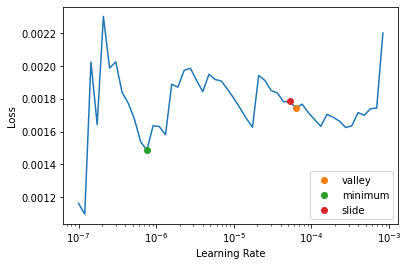

In [30]:
res18_13.lrs()

# Resnet34

## Presize 480/224

In [17]:
presize_cpu = 480
presize_gpu = 224

### wd = 0.1

In [18]:
res34_01 = CNN_Presized(df, get_x, get_y, valid_pct, presize_cpu, presize_gpu, batch_size=256, arch=resnet34, weight_decay=0.1)

SuggestedLRs(valley=0.0020892962347716093, minimum=0.03630780577659607, slide=0.019054606556892395)


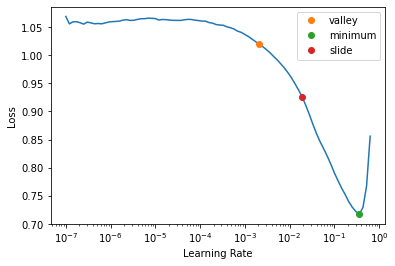

In [19]:
res34_01.lrs()

In [20]:
res34_01.run(6, base_lr='valley')

epoch,train_loss,valid_loss,f1_score,time
0,0.755814,0.351931,0.619125,01:12


Better model found at epoch 0 with valid_loss value: 0.3519313931465149.


epoch,train_loss,valid_loss,f1_score,time
0,0.335474,0.153897,0.884390,01:08
1,0.147724,0.029387,0.968195,01:09
2,0.059316,0.012381,0.985123,01:09
3,0.027307,0.007548,0.991199,01:10
4,0.015519,0.005799,0.993266,01:10
5,0.012072,0.005552,0.993560,01:09


Better model found at epoch 0 with valid_loss value: 0.15389730036258698.
Better model found at epoch 1 with valid_loss value: 0.02938724309206009.
Better model found at epoch 2 with valid_loss value: 0.012381454929709435.
Better model found at epoch 3 with valid_loss value: 0.007548497058451176.
Better model found at epoch 4 with valid_loss value: 0.005798590835183859.
Better model found at epoch 5 with valid_loss value: 0.005552436225116253.


SuggestedLRs(valley=8.31763736641733e-06, minimum=6.309573450380412e-08, slide=0.00013182566908653826)


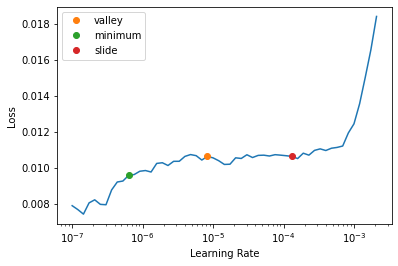

In [21]:
res34_01.lrs()

In [22]:
res34_01.run(2, base_lr='valley')

epoch,train_loss,valid_loss,f1_score,time
0,0.010700,0.005530,0.993453,01:05


Better model found at epoch 0 with valid_loss value: 0.005530188791453838.


epoch,train_loss,valid_loss,f1_score,time
0,0.009747,0.005553,0.993221,01:11
1,0.010049,0.005480,0.993365,01:11


Better model found at epoch 0 with valid_loss value: 0.005552572663873434.
Better model found at epoch 1 with valid_loss value: 0.005480054300278425.


SuggestedLRs(valley=1.737800812406931e-05, minimum=1.0964782268274575e-05, slide=0.00019054606673307717)


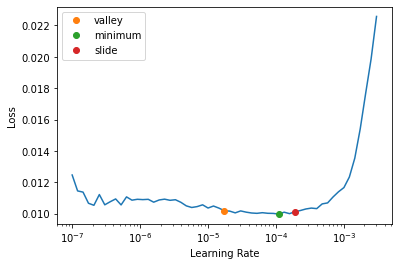

In [23]:
res34_01.lrs()

### wd = 0.2

In [24]:
res34_02 = CNN_Presized(df, get_x, get_y, valid_pct, presize_cpu, presize_gpu, batch_size=256, arch=resnet34, weight_decay=0.2)

SuggestedLRs(valley=0.0020892962347716093, minimum=0.03630780577659607, slide=0.019054606556892395)


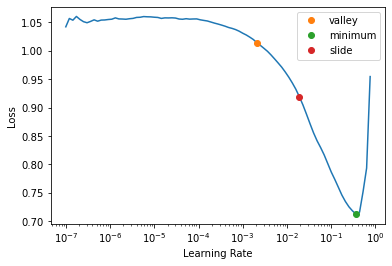

In [25]:
res34_02.lrs()

In [26]:
res34_02.run(6, base_lr='valley')

epoch,train_loss,valid_loss,f1_score,time
0,0.748637,0.355241,0.614655,01:04


Better model found at epoch 0 with valid_loss value: 0.355241060256958.


epoch,train_loss,valid_loss,f1_score,time
0,0.334449,0.145859,0.888050,01:10
1,0.147128,0.031923,0.965456,01:10
2,0.059609,0.012985,0.985344,01:10
3,0.027487,0.009470,0.988658,01:10
4,0.016327,0.006976,0.992303,01:11
5,0.011861,0.006849,0.992394,01:10


Better model found at epoch 0 with valid_loss value: 0.1458590030670166.
Better model found at epoch 1 with valid_loss value: 0.031922776252031326.
Better model found at epoch 2 with valid_loss value: 0.01298479549586773.
Better model found at epoch 3 with valid_loss value: 0.00946967862546444.
Better model found at epoch 4 with valid_loss value: 0.006976105272769928.
Better model found at epoch 5 with valid_loss value: 0.006848953198641539.


SuggestedLRs(valley=5.754399353463668e-06, minimum=1.737800812406931e-06, slide=0.00015848931798245758)


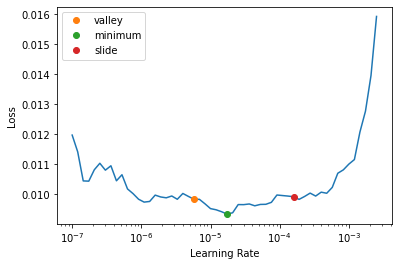

In [27]:
res34_02.lrs()

In [28]:
res34_02.run(2, base_lr='valley')

epoch,train_loss,valid_loss,f1_score,time
0,0.010213,0.006938,0.992296,01:03


Better model found at epoch 0 with valid_loss value: 0.006937574129551649.


epoch,train_loss,valid_loss,f1_score,time
0,0.010280,0.006913,0.991916,01:10
1,0.010878,0.006870,0.992170,01:09


Better model found at epoch 0 with valid_loss value: 0.006912954617291689.
Better model found at epoch 1 with valid_loss value: 0.006870410405099392.


SuggestedLRs(valley=8.31763736641733e-06, minimum=1.737800812406931e-06, slide=0.00015848931798245758)


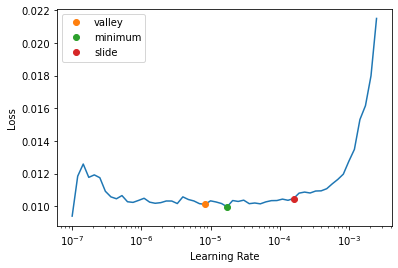

In [29]:
res34_02.lrs()

### wd = 0.3

In [35]:
res34_03 = CNN_Presized(df, get_x, get_y, valid_pct, presize_cpu, presize_gpu, batch_size=256, arch=resnet34, weight_decay=0.3)

SuggestedLRs(valley=0.001737800776027143, minimum=0.03630780577659607, slide=0.019054606556892395)


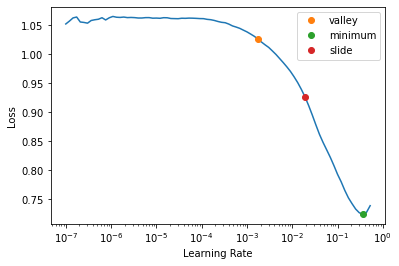

In [36]:
res34_03.lrs()

In [37]:
res34_03.run(6, base_lr='valley')

epoch,train_loss,valid_loss,f1_score,time
0,0.783029,0.423145,0.534541,01:04


Better model found at epoch 0 with valid_loss value: 0.42314520478248596.


epoch,train_loss,valid_loss,f1_score,time
0,0.421122,0.213658,0.825135,01:10
1,0.199529,0.048514,0.957995,01:10
2,0.083415,0.019581,0.979067,01:10
3,0.039144,0.012622,0.986243,01:10
4,0.022953,0.009939,0.988169,01:10
5,0.016814,0.009609,0.988878,01:11


Better model found at epoch 0 with valid_loss value: 0.21365821361541748.
Better model found at epoch 1 with valid_loss value: 0.048514463007450104.
Better model found at epoch 2 with valid_loss value: 0.01958058401942253.
Better model found at epoch 3 with valid_loss value: 0.01262180507183075.
Better model found at epoch 4 with valid_loss value: 0.009939461015164852.
Better model found at epoch 5 with valid_loss value: 0.009608853608369827.


SuggestedLRs(valley=4.365158383734524e-05, minimum=1.9054606673307718e-05, slide=0.0002290867705596611)


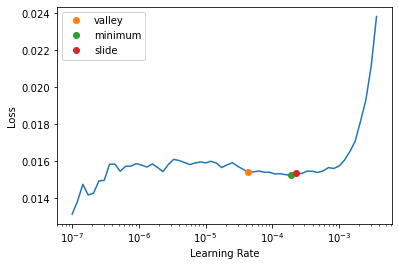

In [38]:
res34_03.lrs()

In [39]:
res34_03.run(2, base_lr='valley')

epoch,train_loss,valid_loss,f1_score,time
0,0.014687,0.009447,0.988846,01:04


Better model found at epoch 0 with valid_loss value: 0.009447088465094566.


epoch,train_loss,valid_loss,f1_score,time
0,0.014178,0.009148,0.989498,01:10
1,0.013835,0.009082,0.989522,01:10


Better model found at epoch 0 with valid_loss value: 0.009148439392447472.
Better model found at epoch 1 with valid_loss value: 0.009081783704459667.


SuggestedLRs(valley=3.0199516913853586e-05, minimum=3.311311302240938e-05, slide=0.0002754228771664202)


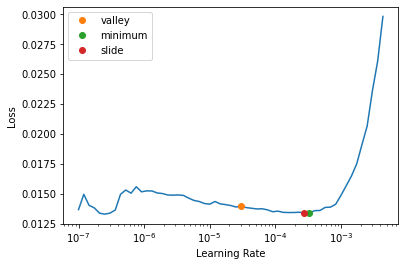

In [40]:
res34_03.lrs()

In [41]:
res34_03.run(2, base_lr='valley')

epoch,train_loss,valid_loss,f1_score,time
0,0.013555,0.008910,0.989630,01:03


Better model found at epoch 0 with valid_loss value: 0.008909688331186771.


epoch,train_loss,valid_loss,f1_score,time
0,0.013795,0.008956,0.989146,01:10
1,0.013463,0.008830,0.989557,01:10


Better model found at epoch 0 with valid_loss value: 0.008955988101661205.
Better model found at epoch 1 with valid_loss value: 0.008830134756863117.


SuggestedLRs(valley=4.365158383734524e-05, minimum=1.3182566908653825e-05, slide=0.00019054606673307717)


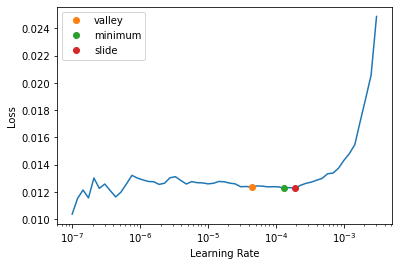

In [42]:
res34_03.lrs()

### wd = 0.4

In [45]:
res34_04 = CNN_Presized(df, get_x, get_y, valid_pct, presize_cpu, presize_gpu, batch_size=256, arch=resnet34, weight_decay=0.4)

SuggestedLRs(valley=0.0014454397605732083, minimum=0.04365158379077912, slide=0.019054606556892395)


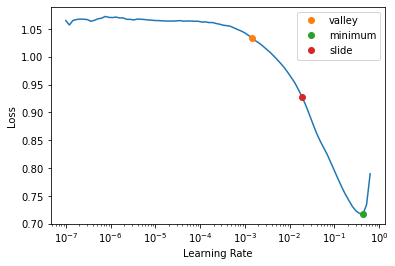

In [46]:
res34_04.lrs()

In [47]:
res34_04.run(6, base_lr='valley')

epoch,train_loss,valid_loss,f1_score,time
0,0.811827,0.432299,0.526232,01:04


Better model found at epoch 0 with valid_loss value: 0.43229949474334717.


epoch,train_loss,valid_loss,f1_score,time
0,0.498959,0.272436,0.763843,01:10
1,0.269017,0.073992,0.944573,01:10
2,0.119792,0.028752,0.974592,01:12
3,0.058658,0.017810,0.982071,01:11
4,0.034945,0.014414,0.985272,01:11
5,0.026236,0.013572,0.985617,01:11


Better model found at epoch 0 with valid_loss value: 0.27243557572364807.
Better model found at epoch 1 with valid_loss value: 0.07399160414934158.
Better model found at epoch 2 with valid_loss value: 0.0287521630525589.
Better model found at epoch 3 with valid_loss value: 0.017810117453336716.
Better model found at epoch 4 with valid_loss value: 0.014413663186132908.
Better model found at epoch 5 with valid_loss value: 0.013571695424616337.


SuggestedLRs(valley=5.754399353463668e-06, minimum=9.12010818865383e-08, slide=0.0003981071640737355)


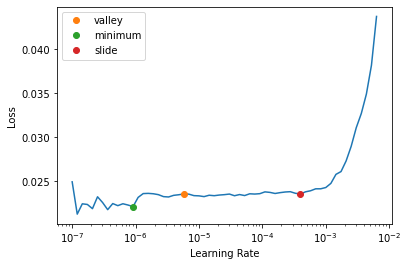

In [48]:
res34_04.lrs()

In [49]:
res34_04.run(2, base_lr='valley')

epoch,train_loss,valid_loss,f1_score,time
0,0.023696,0.013585,0.985522,01:05


Better model found at epoch 0 with valid_loss value: 0.013584657572209835.


epoch,train_loss,valid_loss,f1_score,time
0,0.023841,0.013506,0.985619,01:10
1,0.023537,0.013563,0.985754,01:11


Better model found at epoch 0 with valid_loss value: 0.013506471179425716.


SuggestedLRs(valley=5.248074739938602e-05, minimum=1.58489319801447e-07, slide=0.0003311311302240938)


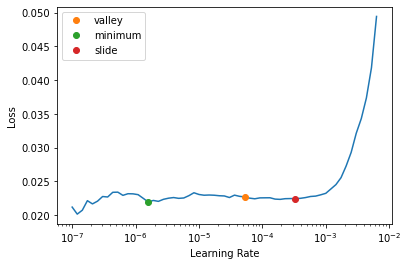

In [50]:
res34_04.lrs()

# Resnet 50

## Presize 480/224

In [17]:
presize_cpu = 480
presize_gpu = 224

### wd = 0.1

In [18]:
res50_01 = CNN_Presized(df, get_x, get_y, valid_pct, presize_cpu, presize_gpu, batch_size=120, arch=resnet50, weight_decay=0.1)

SuggestedLRs(valley=0.0020892962347716093, minimum=0.03019951581954956, slide=0.015848932787775993)


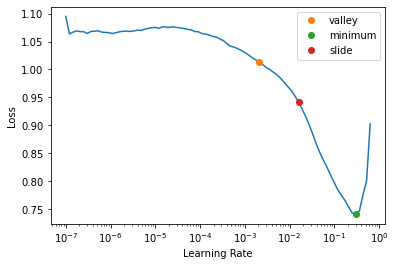

In [19]:
res50_01.lrs()

In [20]:
res50_01.run(6, base_lr='valley')

epoch,train_loss,valid_loss,f1_score,time
0,0.444172,0.119279,0.817017,01:24


Better model found at epoch 0 with valid_loss value: 0.11927904188632965.


epoch,train_loss,valid_loss,f1_score,time
0,0.066455,0.019634,0.974300,01:30
1,0.021952,0.008910,0.987214,01:30
2,0.009787,0.003523,0.996343,01:30
3,0.005271,0.002370,0.996804,01:30
4,0.002413,0.001628,0.998063,01:30
5,0.001523,0.001655,0.998063,01:30


Better model found at epoch 0 with valid_loss value: 0.019633745774626732.
Better model found at epoch 1 with valid_loss value: 0.008909862488508224.
Better model found at epoch 2 with valid_loss value: 0.003522766986861825.
Better model found at epoch 3 with valid_loss value: 0.0023700552992522717.
Better model found at epoch 4 with valid_loss value: 0.001627717399969697.


SuggestedLRs(valley=5.248074739938602e-05, minimum=3.981071640737355e-05, slide=4.365158383734524e-05)


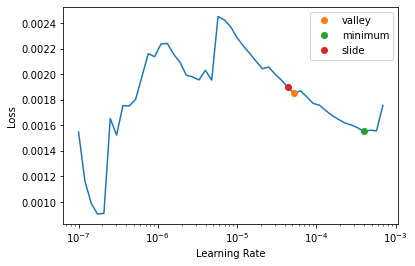

In [21]:
res50_01.lrs()

In [22]:
res50_01.run(2, base_lr='valley')

epoch,train_loss,valid_loss,f1_score,time
0,0.001812,0.001633,0.997956,01:20


Better model found at epoch 0 with valid_loss value: 0.001632552477531135.


epoch,train_loss,valid_loss,f1_score,time
0,0.001729,0.001574,0.998276,01:31
1,0.001635,0.001596,0.998276,01:31


Better model found at epoch 0 with valid_loss value: 0.001573986024595797.


SuggestedLRs(valley=9.999999747378752e-06, minimum=3.6307807022240014e-06, slide=3.0199516913853586e-05)


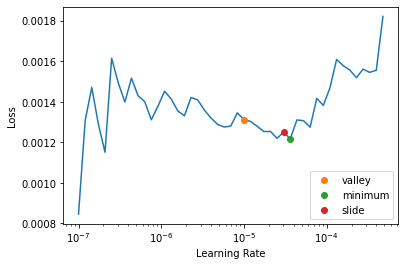

In [23]:
res50_01.lrs()

### wd = 0.2

In [17]:
res50_02 = CNN_Presized(df, get_x, get_y, valid_pct, presize_cpu, presize_gpu, batch_size=120, arch=resnet50, weight_decay=0.2)

SuggestedLRs(valley=0.0020892962347716093, minimum=0.03019951581954956, slide=0.015848932787775993)


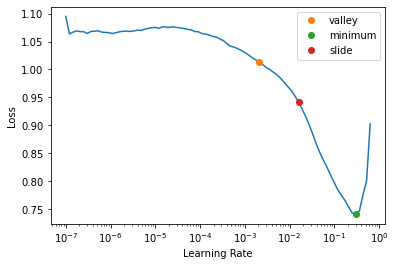

In [18]:
res50_02.lrs()

In [19]:
res50_02.run(6, base_lr='valley')

epoch,train_loss,valid_loss,f1_score,time
0,0.444316,0.119943,0.814998,01:18


Better model found at epoch 0 with valid_loss value: 0.11994313448667526.


epoch,train_loss,valid_loss,f1_score,time
0,0.066746,0.020409,0.973886,01:30
1,0.021268,0.008046,0.987528,01:30
2,0.009952,0.004191,0.992485,01:31
3,0.004914,0.002040,0.997055,01:30
4,0.002210,0.001598,0.997944,01:31
5,0.001654,0.001511,0.998517,01:31


Better model found at epoch 0 with valid_loss value: 0.02040899731218815.
Better model found at epoch 1 with valid_loss value: 0.008045725524425507.
Better model found at epoch 2 with valid_loss value: 0.004191356711089611.
Better model found at epoch 3 with valid_loss value: 0.002040293999016285.
Better model found at epoch 4 with valid_loss value: 0.0015984262572601438.
Better model found at epoch 5 with valid_loss value: 0.0015114916022866964.


SuggestedLRs(valley=3.630780702224001e-05, minimum=6.309573450380412e-08, slide=3.0199516913853586e-05)


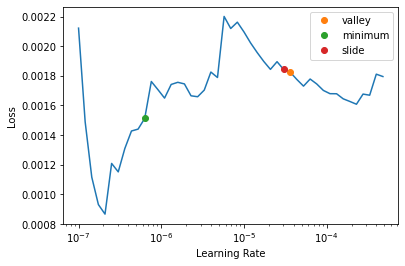

In [20]:
res50_02.lrs()

In [21]:
res50_02.run(2, base_lr='valley')

epoch,train_loss,valid_loss,f1_score,time
0,0.001751,0.001494,0.998412,01:20


Better model found at epoch 0 with valid_loss value: 0.0014938591048121452.


epoch,train_loss,valid_loss,f1_score,time
0,0.001433,0.001419,0.998492,01:31
1,0.001526,0.001480,0.998389,01:31


Better model found at epoch 0 with valid_loss value: 0.0014189667999744415.


SuggestedLRs(valley=6.918309736647643e-06, minimum=4.365158383734525e-06, slide=3.0199516913853586e-05)


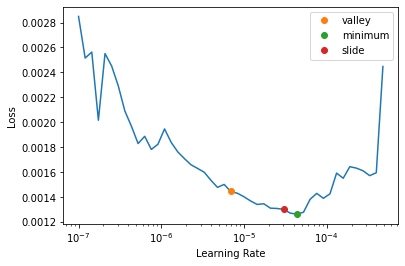

In [22]:
res50_02.lrs()

### wd = 0.3

In [18]:
res50_03 = CNN_Presized(df, get_x, get_y, valid_pct, presize_cpu, presize_gpu, batch_size=120, arch=resnet50, weight_decay=0.3)

SuggestedLRs(valley=0.0020892962347716093, minimum=0.03019951581954956, slide=0.015848932787775993)


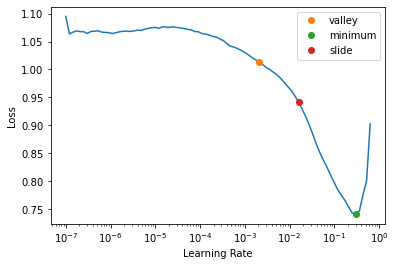

In [19]:
res50_03.lrs()

In [20]:
res50_03.run(6, base_lr='valley')

epoch,train_loss,valid_loss,f1_score,time
0,0.444219,0.121363,0.815197,01:18


Better model found at epoch 0 with valid_loss value: 0.1213625818490982.


epoch,train_loss,valid_loss,f1_score,time
0,0.066745,0.019966,0.974715,01:30
1,0.021534,0.008560,0.988072,01:30
2,0.009267,0.003950,0.994007,01:31
3,0.005121,0.002754,0.995980,01:30
4,0.002234,0.001601,0.997792,01:31
5,0.001575,0.001478,0.998109,01:31


Better model found at epoch 0 with valid_loss value: 0.01996603235602379.
Better model found at epoch 1 with valid_loss value: 0.008559868671000004.
Better model found at epoch 2 with valid_loss value: 0.003950021229684353.
Better model found at epoch 3 with valid_loss value: 0.0027535133995115757.
Better model found at epoch 4 with valid_loss value: 0.0016013177810236812.
Better model found at epoch 5 with valid_loss value: 0.0014779496705159545.


SuggestedLRs(valley=7.585775892948732e-05, minimum=2.290867705596611e-05, slide=3.630780702224001e-05)


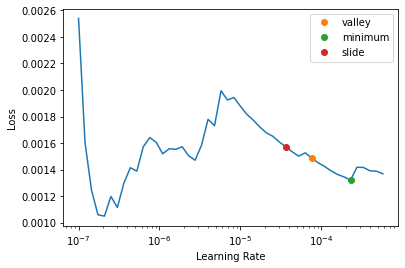

In [21]:
res50_03.lrs()

# Resnet101

## Presize 480/224

In [17]:
presize_cpu = 480
presize_gpu = 224

### wd = 0.1

In [18]:
resnet101_01 = CNN_Presized(df, get_x, get_y, valid_pct, presize_cpu, presize_gpu, batch_size=70, arch=resnet101, weight_decay=0.1)

SuggestedLRs(valley=0.0030199517495930195, minimum=0.03019951581954956, slide=0.013182567432522774)


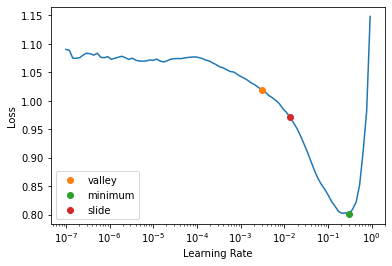

In [19]:
resnet101_01.lrs()

In [20]:
resnet101_01.run(6, base_lr='valley')

epoch,train_loss,valid_loss,f1_score,time
0,0.195942,0.062563,0.882785,01:52


Better model found at epoch 0 with valid_loss value: 0.06256292760372162.


epoch,train_loss,valid_loss,f1_score,time
0,0.022810,0.013215,0.976774,02:17
1,0.019872,0.008218,0.986289,02:17
2,0.011510,0.006069,0.987926,02:18
3,0.006104,0.004049,0.993565,02:18
4,0.002438,0.002089,0.997918,02:18
5,0.001050,0.001921,0.998053,02:18


Better model found at epoch 0 with valid_loss value: 0.013214897364377975.
Better model found at epoch 1 with valid_loss value: 0.00821756012737751.
Better model found at epoch 2 with valid_loss value: 0.006068611517548561.
Better model found at epoch 3 with valid_loss value: 0.004048769362270832.
Better model found at epoch 4 with valid_loss value: 0.002089280867949128.
Better model found at epoch 5 with valid_loss value: 0.001920912996865809.


SuggestedLRs(valley=4.365158383734524e-05, minimum=1.9054607491852948e-07, slide=1.737800812406931e-05)


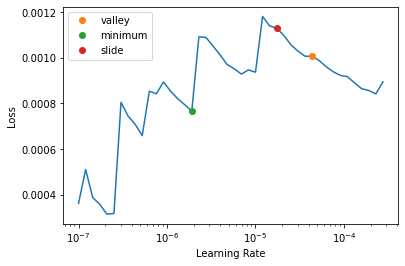

In [21]:
resnet101_01.lrs()

### wd = 0.2

In [17]:
resnet101_02 = CNN_Presized(df, get_x, get_y, valid_pct, presize_cpu, presize_gpu, batch_size=70, arch=resnet101, weight_decay=0.2)

SuggestedLRs(valley=0.0030199517495930195, minimum=0.03019951581954956, slide=0.013182567432522774)


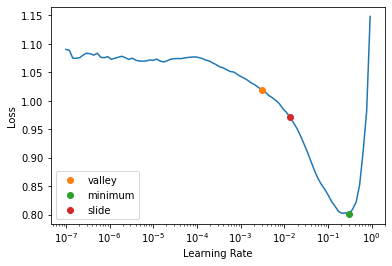

In [18]:
resnet101_02.lrs()

In [19]:
resnet101_02.run(6, base_lr='valley')

epoch,train_loss,valid_loss,f1_score,time
0,0.196571,0.062370,0.887419,01:54


Better model found at epoch 0 with valid_loss value: 0.062370069324970245.


epoch,train_loss,valid_loss,f1_score,time
0,0.022654,0.012108,0.981043,02:18
1,0.017589,0.020243,0.961542,02:18
2,0.011646,0.004567,0.992759,02:18
3,0.005601,0.002402,0.996697,02:18
4,0.001525,0.001914,0.997706,02:18
5,0.001069,0.001486,0.998305,02:18


Better model found at epoch 0 with valid_loss value: 0.012108095921576023.
Better model found at epoch 2 with valid_loss value: 0.004567300900816917.
Better model found at epoch 3 with valid_loss value: 0.0024020597338676453.
Better model found at epoch 4 with valid_loss value: 0.001914281747303903.
Better model found at epoch 5 with valid_loss value: 0.0014858486829325557.


SuggestedLRs(valley=9.120108734350652e-05, minimum=6.309573450380412e-08, slide=5.248074739938602e-05)


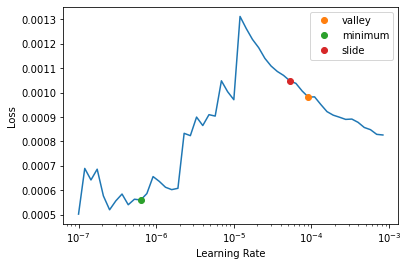

In [20]:
resnet101_02.lrs()